In [1]:
import numpy as np
import os
import urllib
import gzip
import struct

In [2]:
def download_data(url, force_download=False): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

In [4]:
path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

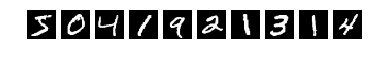

label: [5 0 4 1 9 2 1 3 1 4]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

In [6]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)

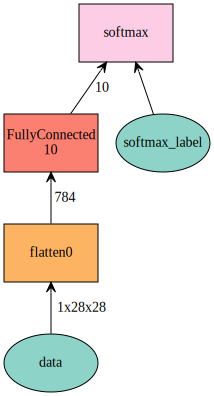

In [7]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc1  = mx.sym.FullyConnected(data=data, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc1, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [8]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  
/mxnet/python/mxnet/model.py:516: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 3419.24 samples/sec	Train-accuracy=0.832950
INFO:root:Epoch[0] Batch [400]	Speed: 3490.91 samples/sec	Train-accuracy=0.877650
INFO:root:Epoch[0] Batch [600]	Speed: 3426.45 samples/sec	Train-accuracy=0.894900
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=17.426
INFO:root:Epoch[0] Validation-accuracy=0.900700
INFO:root:Epoch[1] Batch [200]	Speed: 3159.85 samples/sec	Train-accuracy=0.899300
INFO:root:Epoch[1] Batch [400]	Speed: 3886.74 samples/sec	Train-accuracy=0.897300
INFO:root:Epoch[1] Batch [600]	Speed: 3306.96 samples/s

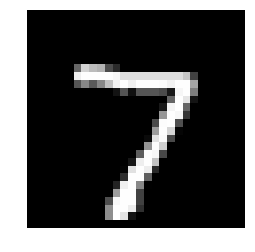

predicted 7
actual 7


0 0.004554%
1 0.000001%
2 0.010959%
3 0.288109%
4 0.000169%
5 0.002075%
6 0.000002%
7 99.651623%
8 0.002606%
9 0.039906%


In [73]:
idx = 0
plt.imshow(val_img[idx], cmap='Greys_r')
plt.axis('off')
plt.show()

test = mx.io.NDArrayIter(to4d(val_img)[idx], None, 1)
predictions = model.predict(test)[0].tolist()
print "predicted {}".format(predictions.index(max(predictions)))
print "actual {}".format(val_lbl[idx])
print "\n"
for i, v in enumerate(predictions):
    print "{} {:02f}%".format(i, v * 100)


In [68]:
for idx in range(0, 1000):
    test = mx.io.NDArrayIter(to4d(val_img)[idx], None, 1)
    predictions = model.predict(test)[0].tolist()
    maxed = predictions.index(max(predictions))
    if not maxed == val_lbl[idx]:
        print idx
    


8
33
63
66
77
92
124
149
193
195
211
217
233
241
245
247
259
290
300
307
313
318
320
321
340
341
352
359
362
381
412
435
444
445
448
449
468
469
478
479
502
507
511
531
536
542
543
551
565
569
578
582
591
613
619
627
628
629
658
659
684
691
692
707
717
720
728
738
740
741
760
781
791
839
844
857
877
881
882
898
924
938
939
947
950
956
959
965
975
982
999
